<a href="https://colab.research.google.com/github/ryybiinana1/HW_Ml_course/blob/main/hw_6_semantic_segmentation_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>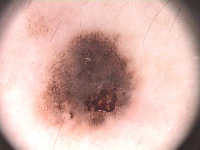</td><td>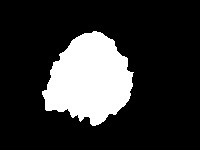</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [2]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=e7cd0e8e-921c-430c-b371-7eb92c80f738
To: /content/PH2Dataset.rar
100% 162M/162M [00:01<00:00, 126MB/s]


In [3]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [4]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [5]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [6]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

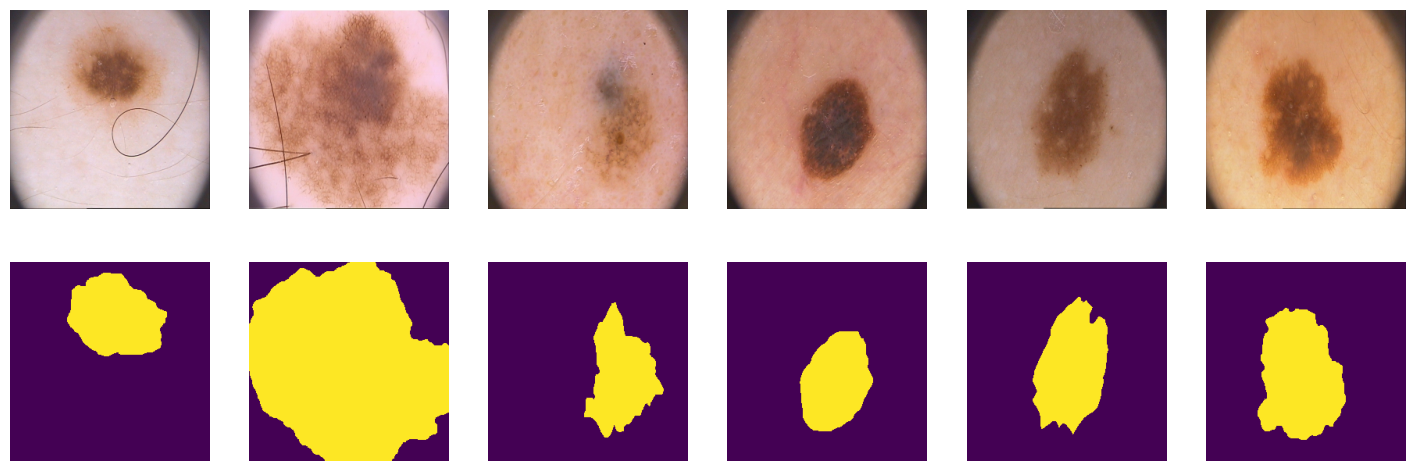

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [8]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [9]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

Так как данных крайне мало для обучения полноценной нейронной сети (train - 100 картинок,
validation - 50 картинок,
test - 50 картинок), **добавим аугментации** + аугметированные картинки добавим в датасет для его расширения


In [10]:
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Аугментации для тренировочных данных
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5), # случайный горизонтальный флип с вероятностью 50%
    A.VerticalFlip(p=0.5), # случайный вертикальный флип с вероятностью 50%
    A.RandomRotate90(p=0.5), # поворот
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5), # сдвиг, масштабирование, поворот изображения
    A.RandomBrightnessContrast(p=0.5), # случайно меняет яркость/контраст
    A.Normalize(mean=(0.5,), std=(0.5,)), # нормализация каналов (приведение к mean=0.5, std=0.5).
    ToTensorV2(), # Преведение к тензору
])

# Для валидации только нормализация
valid_transform = A.Compose([
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

class SegmentationDataset(Dataset):
    def __init__(self, images, masks, transform=None, augment_times=0):
        """
        images, masks: numpy arrays
        transform: albumentations transform
        augment_times: сколько аугментированных копий создать для каждого изображения
        """
        self.images = []
        self.masks = []
        self.transform = transform

        for img, mask in zip(images, masks): # Проходим по всем парам картинок и масок
            # Добавляем оригинал
            self.images.append(img) # сохраняем оригинальные изображения и маски
            self.masks.append(mask)

            # Создаём несколько аугментированных копий
            for _ in range(augment_times): # кол-во augment_times - кол-во жополнительных копий
                if self.transform:
                    augmented = self.transform(image=img, mask=mask)
                    self.images.append(augmented['image'].permute(1, 2, 0).numpy())  # обратно в HWC для согласованности
                    self.masks.append(augmented['mask'].numpy())

        self.images = np.stack(self.images) # собираем все в один numpy массив
        self.masks = np.stack(self.masks)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.unsqueeze(0)  # добавляем канал в маску


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [11]:
from torch.utils.data import DataLoader

batch_size = 25

# train: augment_times=5
train_dataset = SegmentationDataset(X[tr], Y[tr], transform=train_transform, augment_times=5)

# valid: без увеличения набора
valid_dataset = SegmentationDataset(X[val], Y[val], transform=valid_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


test_dataset = SegmentationDataset(X[ts], Y[ts], transform=valid_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [34]:
print(f"Train set size: {len(train_dataset)}") # 1 оригинал + 5 аугментаций для каждого
print(f"Valid set size: {len(valid_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Train set size: 600
Valid set size: 50
Test set size: 50


Видим, что train_dataset удалось увеличить до 600 экземпляров для обучения нейросети

In [12]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
import torch

print("torch version:", torch.__version__)
print("cuda version:", torch.version.cuda)
print("is cuda available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("device name:", torch.cuda.get_device_name(0))
else:
    print("CUDA device not available")


torch version: 2.6.0+cu124
cuda version: 12.4
is cuda available: True
device name: Tesla T4


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [13]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**
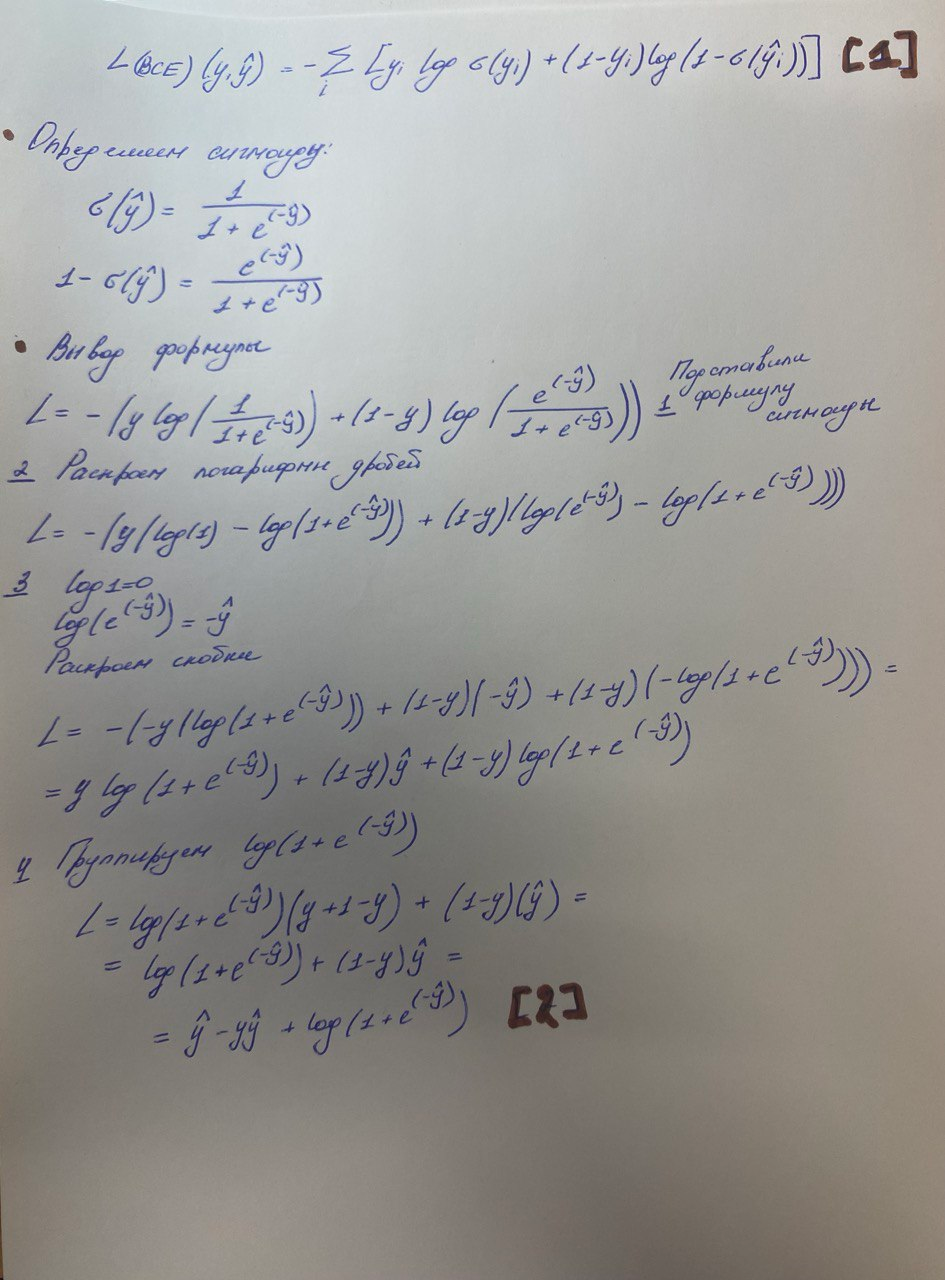

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [15]:
import torch.nn.functional as F
import torch.nn as nn

In [16]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [17]:
def bce_loss(y_pred, y_real):
  l = -1 * ((y_real * torch.log(torch.sigmoid(y_pred)) + (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred)))).sum()
  return l

def bce_true(y_pred, y_real):
  l = (y_pred - y_real * y_pred + torch.log(1 + torch.exp(-1 * (y_pred)))).sum()
  return l

Проверим корректность работы на простом примере

In [18]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss = 4.217838287353516
BCE loss честно посчитанный = 4.217838287353516
BCE loss from torch bce_torch = 4.217838764190674
BCE loss from torch with logits bce_torch = 4.217838764190674


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [ ]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 15.176175117492676
BCE loss честно посчитанный = 15.17617416381836
BCE loss from torch bce_torch = 15.176175117492676
BCE loss from torch with logits bce_torch = 15.17617416381836


In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [ ]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /content/for_asserts/labels.pt
100% 1.18k/1.18k [00:00<00:00, 6.00MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /content/for_asserts/logits.pt
100% 1.18k/1.18k [00:00<00:00, 6.45MB/s]
Download completed


In [ ]:
path_to_dummy_samples = '/content/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

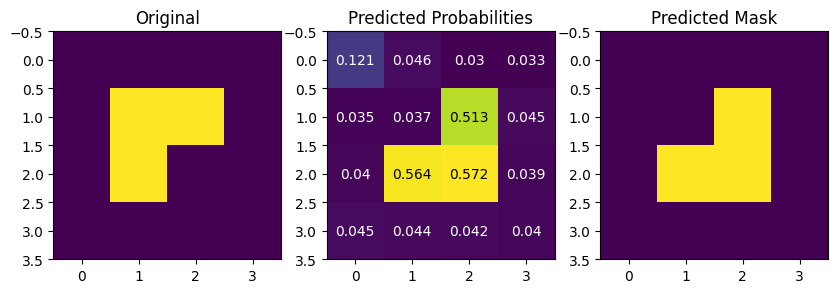

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [ ]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

In [ ]:
print(bce_loss_score)
print(bce_true_score)
print(bce_torch_score)
print(bce_torch_with_logits_score)

tensor(5.9743)
tensor(5.9743)
tensor(5.9743)
tensor(5.9743)


## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

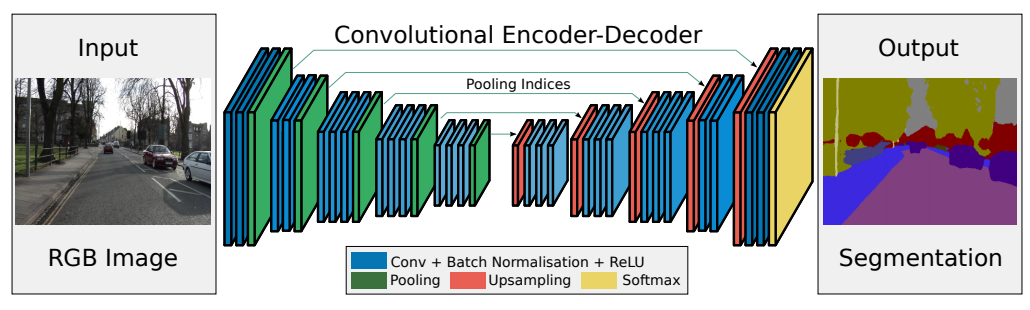

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

**SegNet** построена на основе **VGG-16** (использует её энкодерную часть).
Выведем структуру VGG-16, чтобы воспользоваться ее архитектурой при построении модели

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
import torchvision.models as models

model_ft = models.vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_ft

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [30]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        # VGG-16 architecture
        # encoder
        self.enc_conv0 = nn.Conv2d(3, 64, kernel_size = 3, padding = 1)
        self.enc_conv1 = nn.Conv2d(64, 64, kernel_size = 3, padding = 1)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        self.enc_conv3 = nn.Conv2d(128, 128, kernel_size = 3, padding = 1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc_conv4 = nn.Conv2d(128, 256, kernel_size = 3, padding = 1)
        self.enc_conv5 = nn.Conv2d(256, 256, kernel_size = 3, padding = 1)
        self.enc_conv6 = nn.Conv2d(256, 256, kernel_size = 3, padding = 1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc_conv7 = nn.Conv2d(256, 512, kernel_size = 3, padding = 1)
        self.enc_conv8 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.enc_conv9 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc_conv10 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.enc_conv11 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.enc_conv12 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(512, 512, kernel_size=1)

        # decoder (upsampling)
        self.unpool4 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv12 = nn.Conv2d(512, 512, 3, padding=1)
        self.dec_conv11 = nn.Conv2d(512, 512, 3, padding=1)
        self.dec_conv10 = nn.Conv2d(512, 512, 3, padding=1)

        self.unpool3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv9 = nn.Conv2d(512, 512, 3, padding=1)
        self.dec_conv8 = nn.Conv2d(512, 512, 3, padding=1)
        self.dec_conv7 = nn.Conv2d(512, 256, 3, padding=1)

        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.dec_conv5 = nn.Conv2d(256, 256, 3, padding=1)
        self.dec_conv4 = nn.Conv2d(256, 128, 3, padding=1)

        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv3 = nn.Conv2d(128, 128, 3, padding=1)
        self.dec_conv2 = nn.Conv2d(128, 64, 3, padding=1)

        self.unpool0 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.dec_conv0 = nn.Conv2d(64, out_channels, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = F.relu(self.enc_conv1(F.relu(self.enc_conv0(x))))
        p0, idx0 = self.pool0(e0)

        e1 = F.relu(self.enc_conv3(F.relu(self.enc_conv2(p0))))
        p1, idx1 = self.pool1(e1)

        e2 = F.relu(self.enc_conv6(F.relu(self.enc_conv5(F.relu(self.enc_conv4(p1))))))
        p2, idx2 = self.pool2(e2)

        e3 = F.relu(self.enc_conv9(F.relu(self.enc_conv8(F.relu(self.enc_conv7(p2))))))
        p3, idx3 = self.pool3(e3)

        e4 = F.relu(self.enc_conv12(F.relu(self.enc_conv11(F.relu(self.enc_conv10(p3))))))
        p4, idx4 = self.pool4(e4)

        # bottleneck
        b = self.bottleneck_conv(p4)

        # decoder
        d0 = self.unpool4(b, idx4, output_size=e4.size())
        d0 = F.relu(self.dec_conv12(d0))
        d0 = F.relu(self.dec_conv11(d0))
        d0 = F.relu(self.dec_conv10(d0))

        d1 = self.unpool3(d0, idx3, output_size=e3.size())
        d1 = F.relu(self.dec_conv9(d1))
        d1 = F.relu(self.dec_conv8(d1))
        d1 = F.relu(self.dec_conv7(d1))

        d2 = self.unpool2(d1, idx2, output_size=e2.size())
        d2 = F.relu(self.dec_conv6(d2))
        d2 = F.relu(self.dec_conv5(d2))
        d2 = F.relu(self.dec_conv4(d2))

        d3 = self.unpool1(d2, idx1, output_size=e1.size())
        d3 = F.relu(self.dec_conv3(d3))
        d3 = F.relu(self.dec_conv2(d3))

        d4 = self.unpool0(d3, idx0, output_size=e0.size())
        d4 = F.relu(self.dec_conv1(d4))
        out = self.dec_conv0(d4)

        return out


In [ ]:
segnet_model = SegNet().to(device)

## Тренировка [1 балл]

Напишите функцию для обучения модели.

Воспользуемся примером из семинара для обучения модели.
Также будем использовать функции **train_single_epoch** и **validate_single_epoch** для визуализации прогресса

In [26]:
from tqdm.notebook import tqdm
import torch
from torchmetrics import JaccardIndex

from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

In [25]:
def train_single_epoch(model, optimizer, criterion, train_dataloader, device):
    model.train()

    avg_loss = 0
    for X_batch, Y_batch in tqdm(train_dataloader):
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        avg_loss += loss

    avg_loss = avg_loss/len(train_dataloader)

    return model, avg_loss

def validate_single_epoch(model, criterion, valid_dataloader, device, plot=False):

    iou_score = JaccardIndex(task="binary").to(device)
    model.eval()

    avg_loss = 0
    avg_iou = 0
    with torch.no_grad():
      for X_batch, Y_batch in tqdm(valid_dataloader):
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          logits = model(X_batch)
          prob   = torch.sigmoid(logits)
          iou = iou_score(prob, Y_batch)
          loss = criterion(logits, Y_batch)
          avg_loss += loss
          avg_iou += iou

    avg_loss = avg_loss/len(valid_dataloader)
    avg_iou = avg_iou/len(valid_dataloader)

    if plot:
        clear_output(wait=True)
        labels = {0: 'Background', 1: 'Lesion'}

        fig, axes = plt.subplots(1, 4, figsize=(4*4, 4*4))

        # исходное изображение
        img = X_batch[0].permute(1, 2, 0).cpu().numpy()
        img = (img * 0.5) + 0.5
        img = np.clip(img, 0, 1)
        axes[0].imshow(img)
        axes[0].set_title("Original")

        # GT-маска
        axes[1].imshow(Y_batch[0,0].cpu(), cmap='gray')
        axes[1].set_title("Ground-truth mask")

        # вероятности
        prob = logits.sigmoid()[0,0].cpu()
        im   = axes[2].imshow(prob, vmin=0, vmax=1, cmap='viridis')
        axes[2].set_title("Predicted P(lesion)")
        fig.colorbar(im, ax=axes[2])

        # бинарная предикция
        axes[3].imshow((prob > 0.5), cmap='gray')
        axes[3].set_title(f"Predicted mask\nIoU = {avg_iou:.3f}")

        plt.show()

    return model, avg_loss, avg_iou

def train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path, plot_loss = False):

    total_train_loss = []
    total_val_loss = []
    total_val_iou = []

    # Создаем списки для хранения метрик по эпохам
    best_val_loss = float('inf')
    best_val_iou = 0

    for epoch in tqdm(range(epochs)):

        model, train_loss = train_single_epoch(model, optimizer, criterion, train_dataloader, device)
        model, val_loss, val_iou = validate_single_epoch(model, criterion, valid_dataloader, device, plot=True)
        val_iou = val_iou.item()
        print(f'Epoch {epoch}: train loss = {train_loss}')
        print(f'Epoch {epoch}: val loss = {val_loss}')
        print(f'Epoch {epoch}: val iou = {val_iou}')

        total_train_loss.append(train_loss.cpu().detach().numpy())
        total_val_loss.append(val_loss.cpu().detach().numpy())
        total_val_iou.append(val_iou)

        if plot_loss:

          fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

          ax1.plot(total_train_loss, label='train loss')
          ax1.plot(total_val_loss, label='val loss')
          ax1.set_title('Loss')
          ax1.legend()

          ax2.plot(total_val_iou, label='val IoU')
          ax2.set_title('IoU')
          ax2.legend()

          plt.show()


        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'{ckpt_path}/epoch_{epoch}_best_val_loss.pt')

        torch.save(model.state_dict(), f'{ckpt_path}/epoch_{epoch}_val_iou.pt')


    statistics = {'train loss': total_train_loss,
                  'val_loss': total_val_loss,
                  'val_iou': total_val_iou}
    print("\n=== Training History ===")
    for epoch_idx in range(len(total_train_loss)):
      print(f"Epoch {epoch_idx}: "
          f"train loss = {total_train_loss[epoch_idx]:.4f}, "
          f"val loss = {total_val_loss[epoch_idx]:.4f}, "
          f"val iou = {total_val_iou[epoch_idx]:.4f}")

    return model, statistics


Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)

        # Dice Loss
        probs = torch.sigmoid(logits)
        targets = targets.float()

        smooth = 1e-5
        intersection = (probs * targets).sum(dim=(1,2,3))
        union = probs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))

        dice_loss = 1 - (2. * intersection + smooth) / (union + smooth)
        dice_loss = dice_loss.mean()

        total_loss = self.bce_weight * bce_loss + self.dice_weight * dice_loss
        return total_loss


In [ ]:
model = SegNet().to(device)

criterion = BCEDiceLoss(bce_weight=0.5, dice_weight=0.5)

In [ ]:
# optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
epochs = 20
ckpt_path = '/content/checkpoints'
os.makedirs(ckpt_path, exist_ok=True)

Ниже было проведено обучение модели в два этапа

1) Обучение модели с использованием lr=3e-4, 20 эпох.
На графике видно, что модель не переобучена и можно продолжать обучение

2) Уменьшение lr до lr=1e-4, 20 эпох

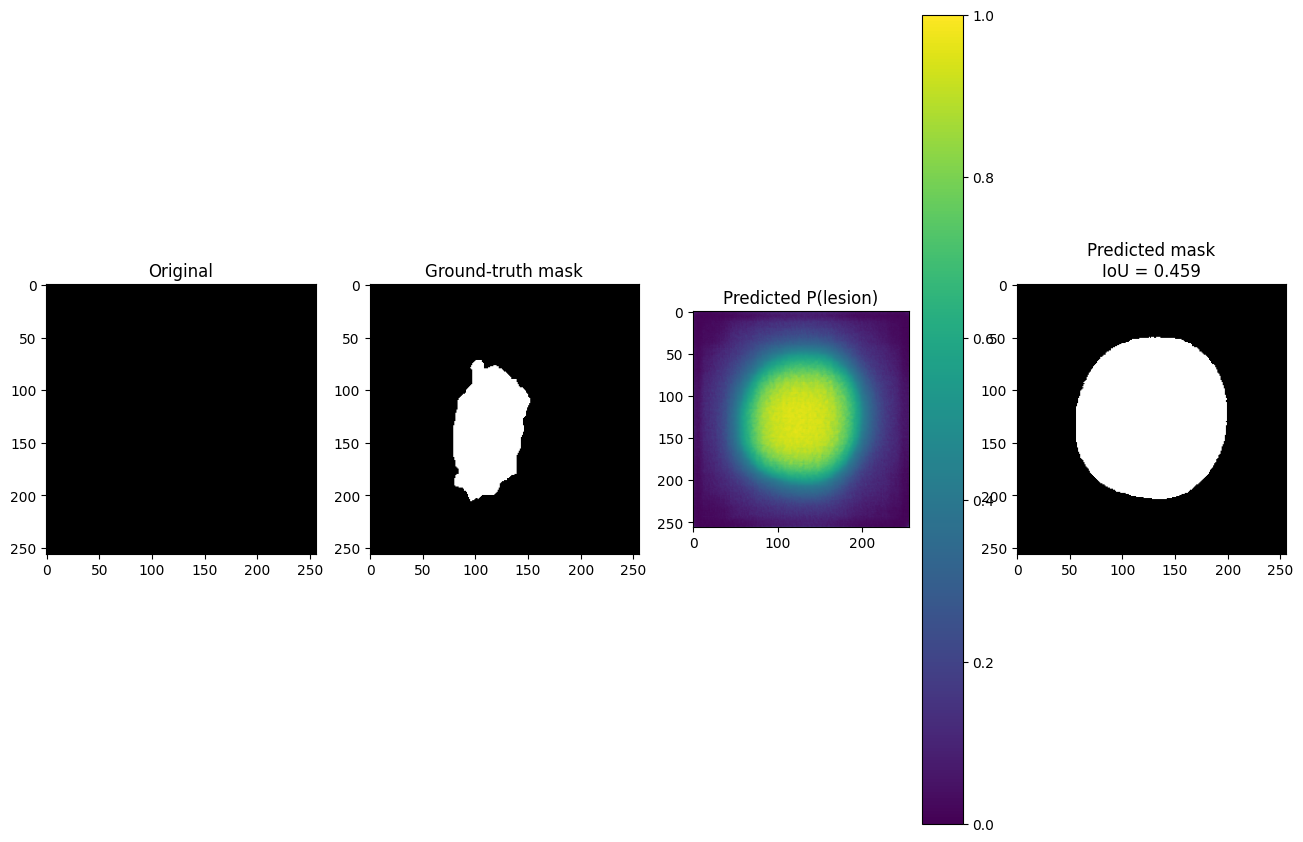

Epoch 19: train loss = 0.4727064371109009
Epoch 19: val loss = 0.47538021206855774
Epoch 19: val iou = 0.4587364196777344


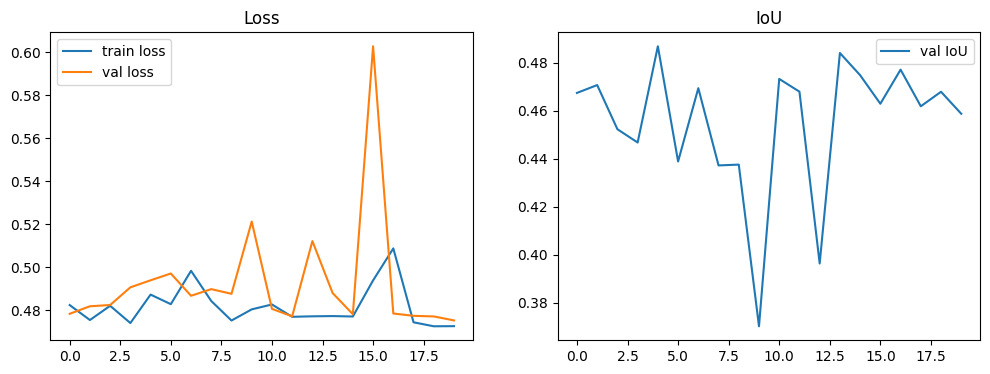


=== Training History ===
Epoch 0: train loss = 0.4825, val loss = 0.4785, val iou = 0.4674
Epoch 1: train loss = 0.4756, val loss = 0.4819, val iou = 0.4707
Epoch 2: train loss = 0.4822, val loss = 0.4825, val iou = 0.4523
Epoch 3: train loss = 0.4741, val loss = 0.4908, val iou = 0.4468
Epoch 4: train loss = 0.4874, val loss = 0.4940, val iou = 0.4869
Epoch 5: train loss = 0.4829, val loss = 0.4972, val iou = 0.4388
Epoch 6: train loss = 0.4984, val loss = 0.4868, val iou = 0.4694
Epoch 7: train loss = 0.4844, val loss = 0.4899, val iou = 0.4372
Epoch 8: train loss = 0.4753, val loss = 0.4877, val iou = 0.4375
Epoch 9: train loss = 0.4805, val loss = 0.5213, val iou = 0.3701
Epoch 10: train loss = 0.4828, val loss = 0.4807, val iou = 0.4733
Epoch 11: train loss = 0.4771, val loss = 0.4773, val iou = 0.4679
Epoch 12: train loss = 0.4773, val loss = 0.5122, val iou = 0.3963
Epoch 13: train loss = 0.4774, val loss = 0.4881, val iou = 0.4841
Epoch 14: train loss = 0.4772, val loss = 0.47

In [ ]:
model, statistics = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path, plot_loss = True)

**Я запустила 20 эпох с lr=3e-4**

Результат:
=== Training History ===
Epoch 0: train loss = 0.6720, val loss = 0.6650, val iou = 0.0000

Epoch 1: train loss = 0.6605, val loss = 0.6639, val iou = 0.0000

Epoch 2: train loss = 0.6341, val loss = 0.6412, val iou = 0.4133

Epoch 3: train loss = 0.6088, val loss = 0.6070, val iou = 0.3706

Epoch 4: train loss = 0.5635, val loss = 0.5435, val iou = 0.4656

Epoch 5: train loss = 0.5343, val loss = 0.5534, val iou = 0.3887

Epoch 6: train loss = 0.5412, val loss = 0.5280, val iou = 0.4732

Epoch 7: train loss = 0.5208, val loss = 0.5141, val iou = 0.4512

Epoch 8: train loss = 0.5224, val loss = 0.5058, val iou = 0.4785

Epoch 9: train loss = 0.5052, val loss = 0.5135, val iou = 0.4454

Epoch 10: train loss = 0.4947, val loss = 0.4924, val iou = 0.4747

Epoch 11: train loss = 0.4929, val loss = 0.5379, val iou = 0.3382

Epoch 12: train loss = 0.4993, val loss = 0.5075, val iou = 0.4549

Epoch 13: train loss = 0.5018, val loss = 0.4887, val iou = 0.4563

Epoch 14: train loss = 0.4809, val loss = 0.4842, val iou = 0.4553

Epoch 15: train loss = 0.4810, val loss = 0.4770, val iou = 0.4673

Epoch 16: train loss = 0.4806, val loss = 0.4880, val iou = 0.4672

Epoch 17: train loss = 0.4890, val loss = 0.4872, val iou = 0.4717

Epoch 18: train loss = 0.4843, val loss = 0.4853, val iou = 0.4441

Epoch 19: train loss = 0.4888, val loss = 0.4828, val iou = 0.4452

**Запустим еще 20 эпох с learning rate = lr=1e-4**

## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [ ]:
def test(model, test_dataloader, device, ckpt_full_path):
    model.load_state_dict(torch.load(ckpt_full_path))
    model = model.to(device)
    model.eval()

    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    avg_iou = 0
    with torch.no_grad():
        for X_batch, Y_batch in test_dataloader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            Y_pred = model(X_batch)
            prob = torch.sigmoid(Y_pred)
            avg_iou += iou_score(prob, Y_batch)

        avg_iou = avg_iou / len(test_dataloader)

    return avg_iou


In [ ]:
avg_iou_test = test(model, test_dataloader, device, "/content/checkpoints/epoch_13_best_val_loss.pt")
print(avg_iou_test)

tensor(0.4760, device='cuda:0')


# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [27]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    eps = 1e-7  # маленькая константа для избежания деления на 0

    probs = torch.sigmoid(logits)  # переводим логиты в вероятности

    # Прямо работаем с вероятностями, без порога
    TP = (probs * labels).sum(dim=(1,2,3))
    FP = (probs * (1 - labels)).sum(dim=(1,2,3))
    FN = ((1 - probs) * labels).sum(dim=(1,2,3))

    dice = (2 * TP + eps) / (2 * TP + FP + FN + eps)

    return dice.mean()


Проверим на корректность функцию dice_score:

In [40]:
from torchmetrics.segmentation import DiceScore

dice = DiceScore(num_classes=1, average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

NameError: name 'dummpy_sample' is not defined

In [ ]:
'''
если вы используете версию библиотеки 0.11.4, то можно взять torchmetrics.classification.Dice():

from torchmetrics.classification import Dice

dice = Dice(average='micro').to(device)

'''

In [21]:
assert dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

NameError: name 'dummpy_sample' is not defined

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [22]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''
    Это лосс.
    '''
    eps = 1e-7

    probs = torch.sigmoid(logits)  # переводим логиты в вероятности

    TP = (probs * labels).sum(dim=(1,2,3))
    FP = (probs * (1 - labels)).sum(dim=(1,2,3))
    FN = ((1 - probs) * labels).sum(dim=(1,2,3))

    dice = (2 * TP + eps) / (2 * TP + FP + FN + eps)

    loss = 1 - dice.mean()

    return loss

Проверка на корректность:

In [ ]:
# проверьте, что у вас установлена библиотека
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.0 MB/s eta 0:00:00


In [ ]:
import segmentation_models_pytorch
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [ ]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [35]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    # Переводим предсказания в вероятности
    probs = torch.sigmoid(y_pred)

    # Считаем pt
    pt = probs * y_real + (1 - probs) * (1 - y_real)  # по формуле pt = p, если y=1, иначе 1-p

    # Стандартный BCE Loss без усреднения
    bce = F.binary_cross_entropy_with_logits(y_pred, y_real, reduction='none')

    # Формула Focal Loss
    loss = ((1 - pt) ** gamma) * bce

    # Складываем всё (reduction='sum' как в проверке)
    return loss.sum()

Проверка корректности функции:

In [ ]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [ ]:
assert sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum') == focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0)

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



1) Запустим модель с использованием dice loss

In [32]:
model_with_dice = SegNet().to(device)

criterion = dice_loss
optimizer = torch.optim.Adam(model_with_dice.parameters(), lr=1e-4, weight_decay=1e-5)
epochs = 20
ckpt_path_dice = '/content/checkpoints_with_dice_loss'
os.makedirs(ckpt_path_dice, exist_ok=True)

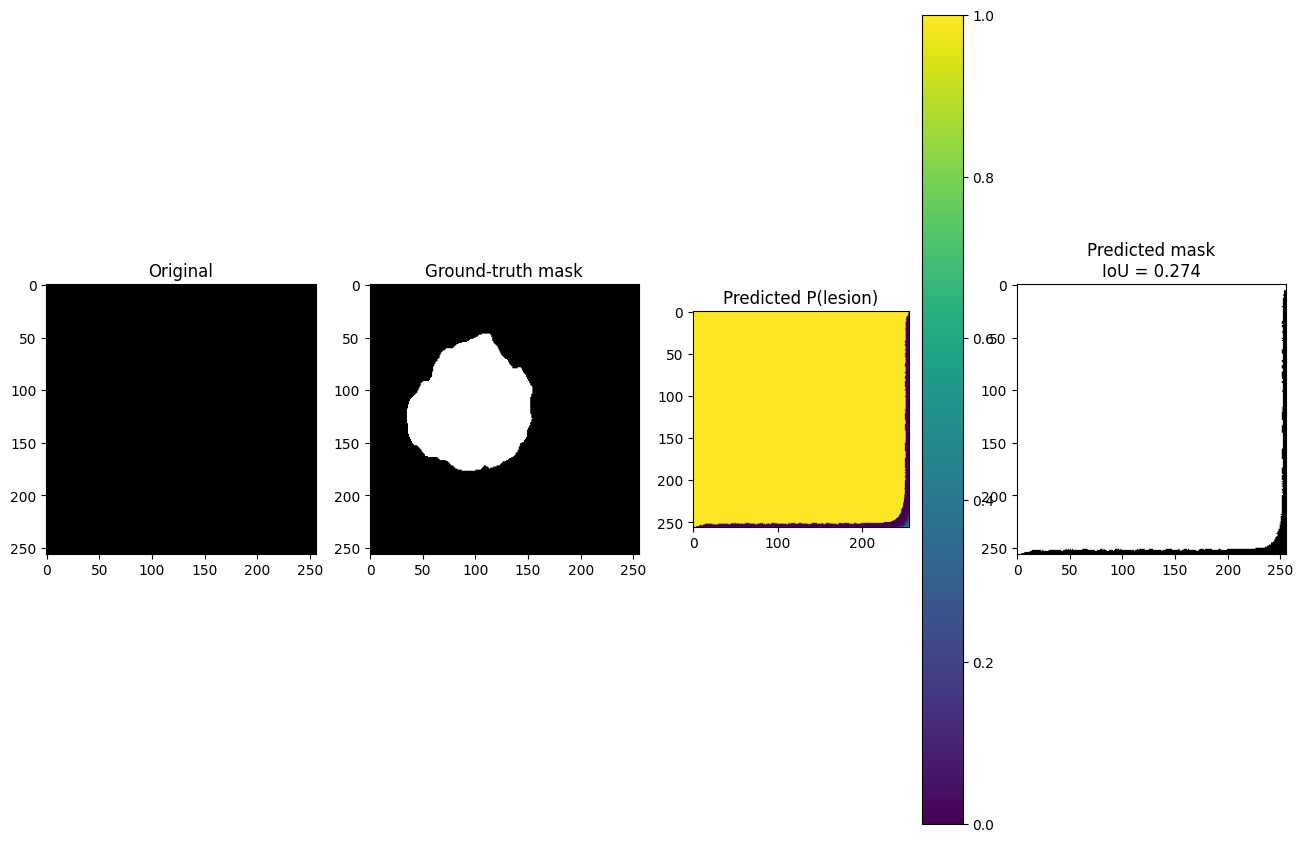

Epoch 19: train loss = 0.5209383368492126
Epoch 19: val loss = 0.6052098274230957
Epoch 19: val iou = 0.27419525384902954


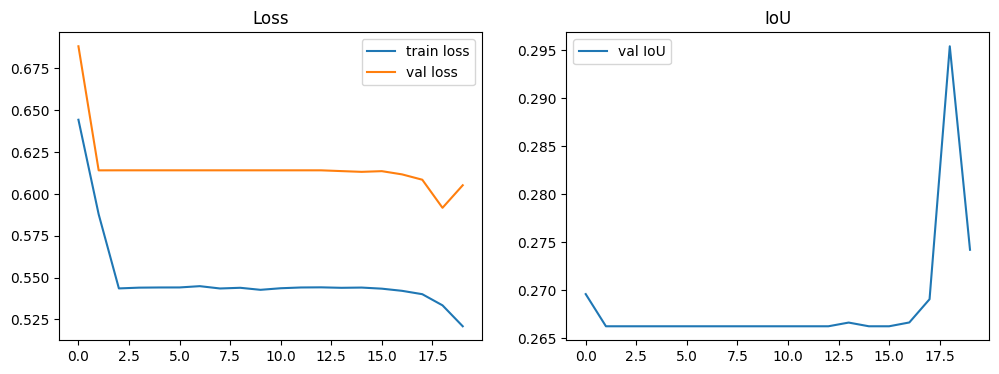


=== Training History ===
Epoch 0: train loss = 0.6443, val loss = 0.6882, val iou = 0.2696
Epoch 1: train loss = 0.5879, val loss = 0.6141, val iou = 0.2662
Epoch 2: train loss = 0.5436, val loss = 0.6141, val iou = 0.2662
Epoch 3: train loss = 0.5440, val loss = 0.6141, val iou = 0.2662
Epoch 4: train loss = 0.5441, val loss = 0.6141, val iou = 0.2662
Epoch 5: train loss = 0.5441, val loss = 0.6141, val iou = 0.2662
Epoch 6: train loss = 0.5449, val loss = 0.6141, val iou = 0.2662
Epoch 7: train loss = 0.5435, val loss = 0.6141, val iou = 0.2662
Epoch 8: train loss = 0.5439, val loss = 0.6141, val iou = 0.2662
Epoch 9: train loss = 0.5427, val loss = 0.6141, val iou = 0.2662
Epoch 10: train loss = 0.5437, val loss = 0.6141, val iou = 0.2662
Epoch 11: train loss = 0.5441, val loss = 0.6141, val iou = 0.2662
Epoch 12: train loss = 0.5442, val loss = 0.6141, val iou = 0.2662
Epoch 13: train loss = 0.5439, val loss = 0.6137, val iou = 0.2666
Epoch 14: train loss = 0.5441, val loss = 0.61

In [33]:
model_with_dice, statistics = train(model_with_dice, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path_dice, plot_loss = True)

2) Запустим модель с использованием focal loss

In [38]:
model_with_focal = SegNet().to(device)

criterion = focal_loss
optimizer = torch.optim.Adam(model_with_focal.parameters(), lr=1e-4, weight_decay=1e-5)
epochs = 20
ckpt_path_focal = '/content/checkpoints_with_dice_loss'
os.makedirs(ckpt_path_focal, exist_ok=True)

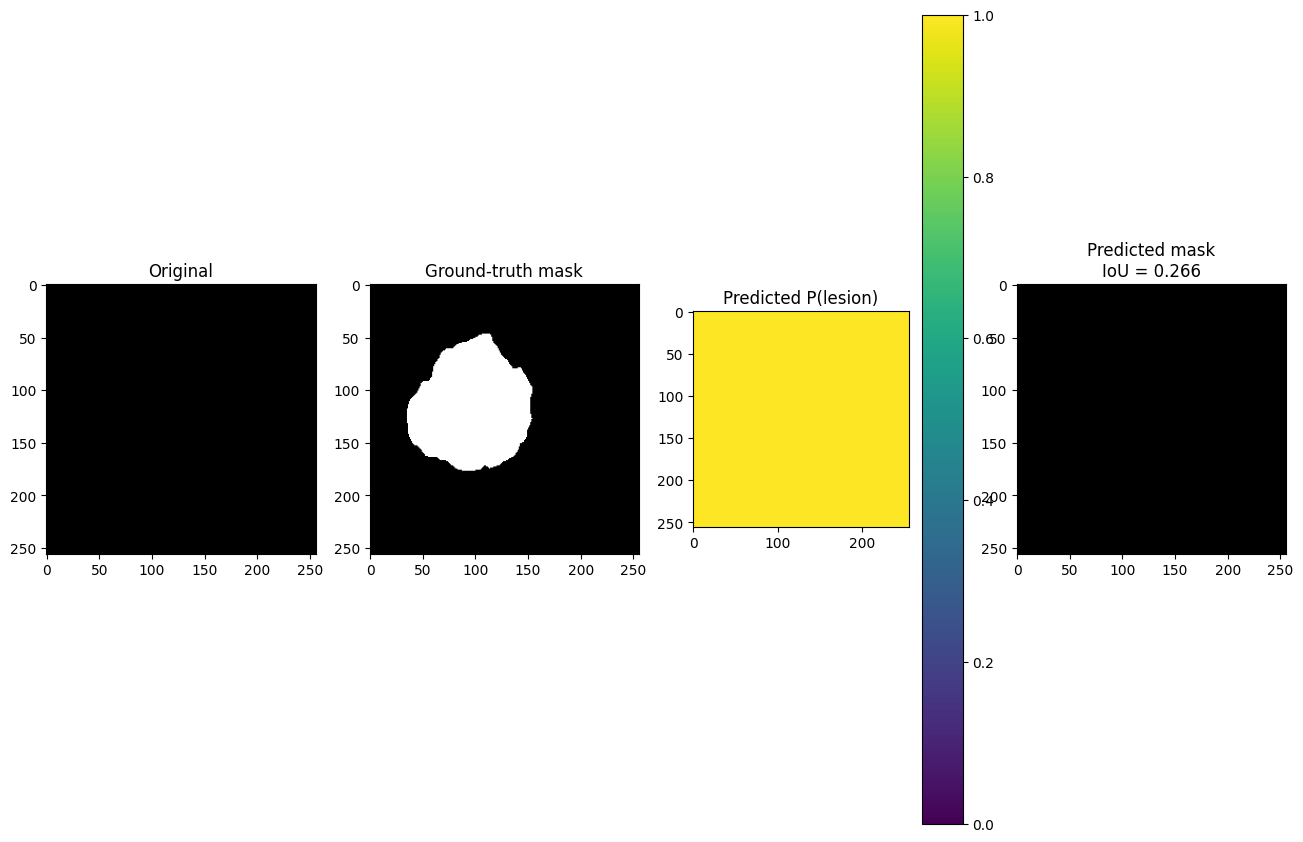

Epoch 19: train loss = -2.1970389245201843e+23
Epoch 19: val loss = -2.344487857184205e+23
Epoch 19: val iou = 0.26622676849365234


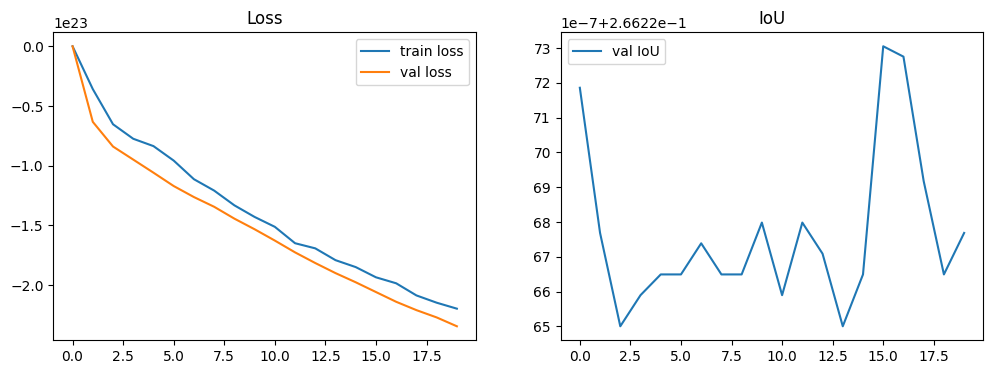


=== Training History ===
Epoch 0: train loss = -31526421457272832.0000, val loss = -21959230725663227904.0000, val iou = 0.2662
Epoch 1: train loss = -35835489012158344200192.0000, val loss = -63266531536503708844032.0000, val iou = 0.2662
Epoch 2: train loss = -65298654767565078790144.0000, val loss = -83945133484748511903744.0000, val iou = 0.2662
Epoch 3: train loss = -77444043307451125071872.0000, val loss = -94881188431095268376576.0000, val iou = 0.2662
Epoch 4: train loss = -83589078898208600489984.0000, val loss = -105840986354677522104320.0000, val iou = 0.2662
Epoch 5: train loss = -95710084949712062906368.0000, val loss = -117020749091259805597696.0000, val iou = 0.2662
Epoch 6: train loss = -111302528644387486826496.0000, val loss = -126252741017801368535040.0000, val iou = 0.2662
Epoch 7: train loss = -120834208104532792049664.0000, val loss = -134388016363085668286464.0000, val iou = 0.2662
Epoch 8: train loss = -133173377529185336033280.0000, val loss = -144319876678919

In [39]:
model_with_focal, statistics_focal = train(model_with_focal, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path_focal, plot_loss = True)

# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

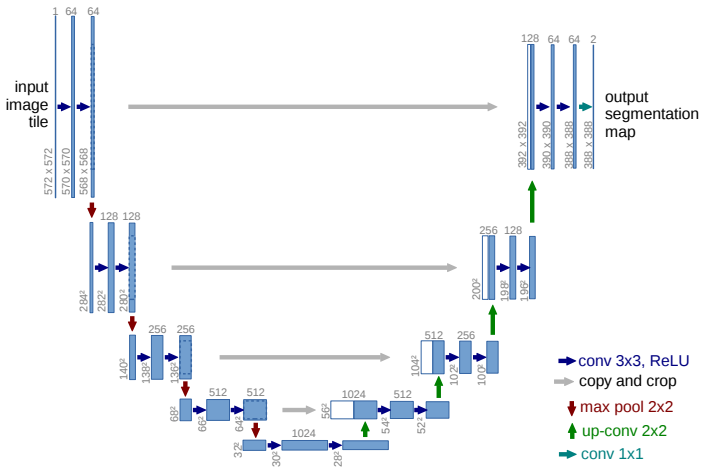

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_class=1):
        super().__init__()

        # TODO

    def forward(self, x):
        #  TODO

        return output

In [ ]:
unet_model = UNet().to(device)

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.

